<a href="https://colab.research.google.com/github/monimoreno2905/SegundoParcial/blob/main/Costos_MMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este código contiene la implementación de un autoencoder variacional para la reconstrucción de imágenes de fasion m-nist. Adicionalmente se utiliza un custom loss definido por maximum mean discrepancy con kernels gausianos.

1. IMPORTAR LIBRERIAS

In [1]:
#Las siguientes dos librerias aseguran que se este usando la versión de python mayor a 3.5
#de lo contrario detendrá la ejecución del programa
import sys
assert sys.version_info >= (3, 5)

# Se verifica que se tenga una versión de sklearn mayor a 0.2.
#La libreria proporciona herramientas para la ejecución de algortimos de clasificación, regresión, etc.
import sklearn
assert sklearn.__version__ >= "0.20"

#Verifica si el entorno en donde se está ejeutando el código es collab
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

#Importa y verifica la versión de tensorflow que es una libreria que sirve para crear modelos de redes neuronales
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Realiza la detección de GPU
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# en este contexto numpy se utiliza para hacer algunas operaciones matemáticas y definir arreglos
import numpy as np
#En este ejercicio básicamente se utiliza para manipular directorios
import os

from tensorflow.keras import layers

# Con esto se garantiza que produzcan los mismos resultados cada vez que se ejecuta el código
np.random.seed(42)
tf.random.set_seed(42)

# Librerias para la generación de gráficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#configurar etiquetas de los ejes, tamaños etc
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


2. FUNCIONES GENERALES

In [2]:
"""Esta funció grafica imágenes originales vs reconstruidas del mnist después de aplicar el modelo encoder, decoder
Los datos que se le ingresa son: el modelo de reconstrucción, las imágenes originales de las cuales siempre se van a graficar cinco"""
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images]) #aplica el modelo de autoencoer para sacar imagenes reconstruidas
    fig = plt.figure(figsize=(n_images * 1.5, 3)) #Establece los parámetros de la figura como por ejemplo el tamaño
    for image_index in range(n_images): #En cada iteración, dibuja la imagen original y su reconstrucción correspondiente en la figura.
        plt.subplot(2, n_images, 1 + image_index) #grafica imágenes originales
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index) #grafica reconstrucciones
        plot_image(reconstructions[image_index])

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
"""Convierte las probabilidades en un problema de clasificación binaria
redondea las etiquetas verdaderas y predichas a un valor binario
esto suele hacerse para realizar una comparación más suave y flexible
La función se utilizará para compilar los modelos más adelante"""
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

3. CARGAR LA BASE DE DATOS FASHION-MNIST:


In [4]:
"""Se carga la base de datos fashion mnist que dispone de imágenes de prendas,
dichas imágenes están en escala de grises y tienen un tamaño de 28x28 píxeles.
Hay 10 clases diferentes"""
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255 #normalización de los datos
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:] #Se toman solo algunos datos, no todos
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


4. DEFINIR MMD COMO FUNCIÓN DE COSTOS

$\text{MMD}^2(\mathcal{F}, p, q) = \mathbb{E}_{x,x' \sim p} \left[ k(x, x') \right] + \mathbb{E}_{y,y' \sim q} \left[ k(y, y') \right] - 2 \mathbb{E}_{x \sim p, y \sim q} \left[ k(x, y) \right]   Ecuación 1$


Se hace uso de un kernel gaussiano

$K(x, x') = \exp \left( - \frac{\| x - x' \|^2}{2 \sigma^2} \right)   Ecuación 2$


In [5]:
#Encontrar el valor óptimo de sigma
from scipy.spatial.distance import cdist, squareform

ind = np.argsort(y_test)
X_test = X_test.reshape(X_test.shape[0],28*28)
D=cdist(X_test[ind],X_test[ind])
tU=squareform(D)
np.median(tU)

11.44417016933987

In [6]:
import tensorflow_probability as tfp

#Se importa un kernel gaussiano con el valor óptimo de sigma
sigma = 11.44  # Valor de sigma óptimo
gaussian_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=sigma) #Kernel gaussiano ecuación 2

#Kernel aplicado a los datos
def kernel_matrix(x, y):
    # Aplanar las imágenes
    x_flat = tf.cast(tf.reshape(x, [tf.shape(x)[0], -1]), tf.float32)  # Aplana x a [x_size, m*n]
    y_flat = tf.cast(tf.reshape(y, [tf.shape(y)[0], -1]), tf.float32)  # Aplana y a [y_size, m*n]

    # Calcular la matriz del kernel
    return gaussian_kernel.matrix(x_flat, y_flat)  # Cambiado a .matrix

#Función de costo mmd
def mmd_loss(x, y):
    xx = kernel_matrix(x, x) #Kernel sobre datos originales vs originales
    yy = kernel_matrix(y, y) #kernel sobre datos reconstruidos vs reconstruidos
    xy = kernel_matrix(x, y) #Kernel sobre datos originales vs reconstruidos

    #Se implementa la raiz cuadrada de la ecuación 1
    return tf.sqrt(tf.reduce_mean(xx) + tf.reduce_mean(yy) - 2 * tf.reduce_mean(xy))

5. ENTRENAMIENTO AUTOENCODER VARIACIONAL

In [7]:
"""Se entrena el sparse autoencoder pero usando mmd como función de costos"""
tf.random.set_seed(42)
np.random.seed(42)

#se establece la arquitectura de manera secuencial
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    #keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.2),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="leaky_relu",kernel_initializer= 'LecunNormal'), #se conserva el tamaño original de las imágenes
    keras.layers.MaxPool2D(pool_size=2), #se aplica pooling, esto permite reducir costo computacional
    keras.layers.ActivityRegularization(l2=1e-3),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="leaky_relu",kernel_initializer= 'LecunNormal'),
    keras.layers.MaxPool2D(pool_size=2),
    #keras.layers.Dropout(rate=0.2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu",kernel_initializer= 'LecunNormal'),
    #kl_loss = kl_regularizer(z)
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.ActivityRegularization(l2=1e-3) #regularizador l2
])
#No se aplicaron cambios significativos, en realidad influyó más en los resultados la modificación del encoder
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="leaky_relu",kernel_initializer= 'LecunNormal',
                                 input_shape=[3, 3, 64]), #primera capa convolucional
    keras.layers.ActivityRegularization(l2=1e-3), #solo se agregó este regularizador
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28]) #imagen reconstruida
])
#compilación del modelo
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss=mmd_loss, optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
                metrics=['mse'])

history = conv_ae.fit(X_train, X_train, epochs=10, batch_size=8,
                      validation_data=(X_valid, X_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.9184 - mse: 0.0713 - val_loss: 0.1845 - val_mse: 0.0248
Epoch 2/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.1728 - mse: 0.0229 - val_loss: 0.1460 - val_mse: 0.0188
Epoch 3/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1409 - mse: 0.0178 - val_loss: 0.1285 - val_mse: 0.0160
Epoch 4/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1251 - mse: 0.0152 - val_loss: 0.1171 - val_mse: 0.0142
Epoch 5/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1149 - mse: 0.0136 - val_loss: 0.1092 - val_mse: 0.0129
Epoch 6/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1079 - mse: 0.0125 - val_loss: 0.1037 - val_mse: 0.0120
Epoch 7/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.1027 - mse: 0.0117 - val_loss: 0.0995 - val_mse: 0.0113
Epoch 8/10
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0988 - mse: 0.0110 - val_loss: 0.0963 - val_mse: 0.0107
Epoch 9/10
6875/6875 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


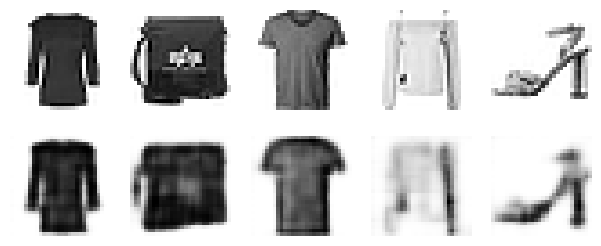

In [8]:
#Se grafican las reconstrucciones vs los datos originales
show_reconstructions(conv_ae,X_valid)
plt.show()

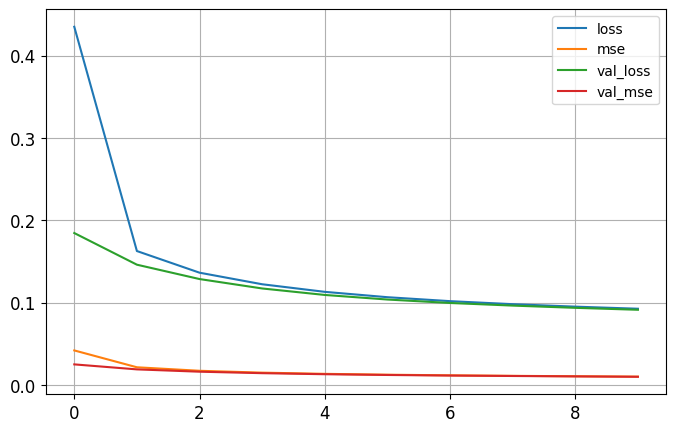

In [9]:
#Se grafica MSE vs MMD
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()